In [9]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class ChangeDetectionDataset(Dataset):
    def __init__(self, current_dir, past_dir, mask_dir, transform=None, mask_transform=None):
        self.current_dir = current_dir
        self.past_dir = past_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_pairs = [f for f in os.listdir(current_dir) if os.path.isfile(os.path.join(past_dir, f)) and os.path.isfile(os.path.join(mask_dir, f))]
    
    def __len__(self):
        return len(self.image_pairs)
    
    def __getitem__(self, idx):
        current_image_path = os.path.join(self.current_dir, self.image_pairs[idx])
        past_image_path = os.path.join(self.past_dir, self.image_pairs[idx])
        mask_path = os.path.join(self.mask_dir, self.image_pairs[idx])
        
        current_image = Image.open(current_image_path).convert('RGB')
        past_image = Image.open(past_image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.transform:
            current_image = self.transform(current_image)
            past_image = self.transform(past_image)
        
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        input_image = torch.cat((current_image, past_image), dim=0)
        
        return input_image, mask, current_image_path

In [10]:
class UNet(nn.Module):
    def __init__(self, in_channels=6, out_channels=1):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        def up_conv(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = conv_block(512, 1024)
        
        self.upconv4 = up_conv(1024, 512)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = up_conv(512, 256)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = up_conv(256, 128)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = up_conv(128, 64)
        self.decoder1 = conv_block(128, 64)
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        
        bottleneck = self.bottleneck(self.pool(enc4))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return torch.sigmoid(self.final_conv(dec1))

In [11]:
# Specify the paths to the current, past, and mask image folders
current_image_path = '/home/hehe/fyp/dataset/val/current'
past_image_path = '/home/hehe/fyp/dataset/val/past'
mask_image_path = '/home/hehe/fyp/dataset/val/masks'

# Define the necessary preprocessing steps for images
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Define the necessary preprocessing steps for masks
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize masks to 256x256
    transforms.ToTensor()  # Convert masks to PyTorch tensors
])

# Create an instance of the dataset
test_dataset = ChangeDetectionDataset(current_dir=current_image_path, past_dir=past_image_path, mask_dir=mask_image_path, transform=image_transform, mask_transform=mask_transform)

# Create a DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [12]:
# Check if CUDA is available and move the model to GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)

# Load the trained model
model_load_path = 'unet_model.pth'
model.load_state_dict(torch.load(model_load_path, map_location=device))
model.eval()

/tmp/ipykernel_17516/818184293.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_location=device))


UNet(
  (encoder1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, strid

In [13]:
# Initialize the loss function
criterion = nn.BCELoss()

# Testing loop
test_loss = 0.0
all_outputs = []
all_masks = []
all_image_paths = []

with torch.no_grad():
    for inputs, masks, image_paths in test_dataloader:
        inputs, masks = inputs.to(device), masks.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, masks)
        test_loss += loss.item()
        
        all_outputs.append(outputs.cpu())
        all_masks.append(masks.cpu())
        all_image_paths.append(image_paths)

test_loss /= len(test_dataloader)
print(f'Test Loss: {test_loss}')

Test Loss: 0.11215790097170004


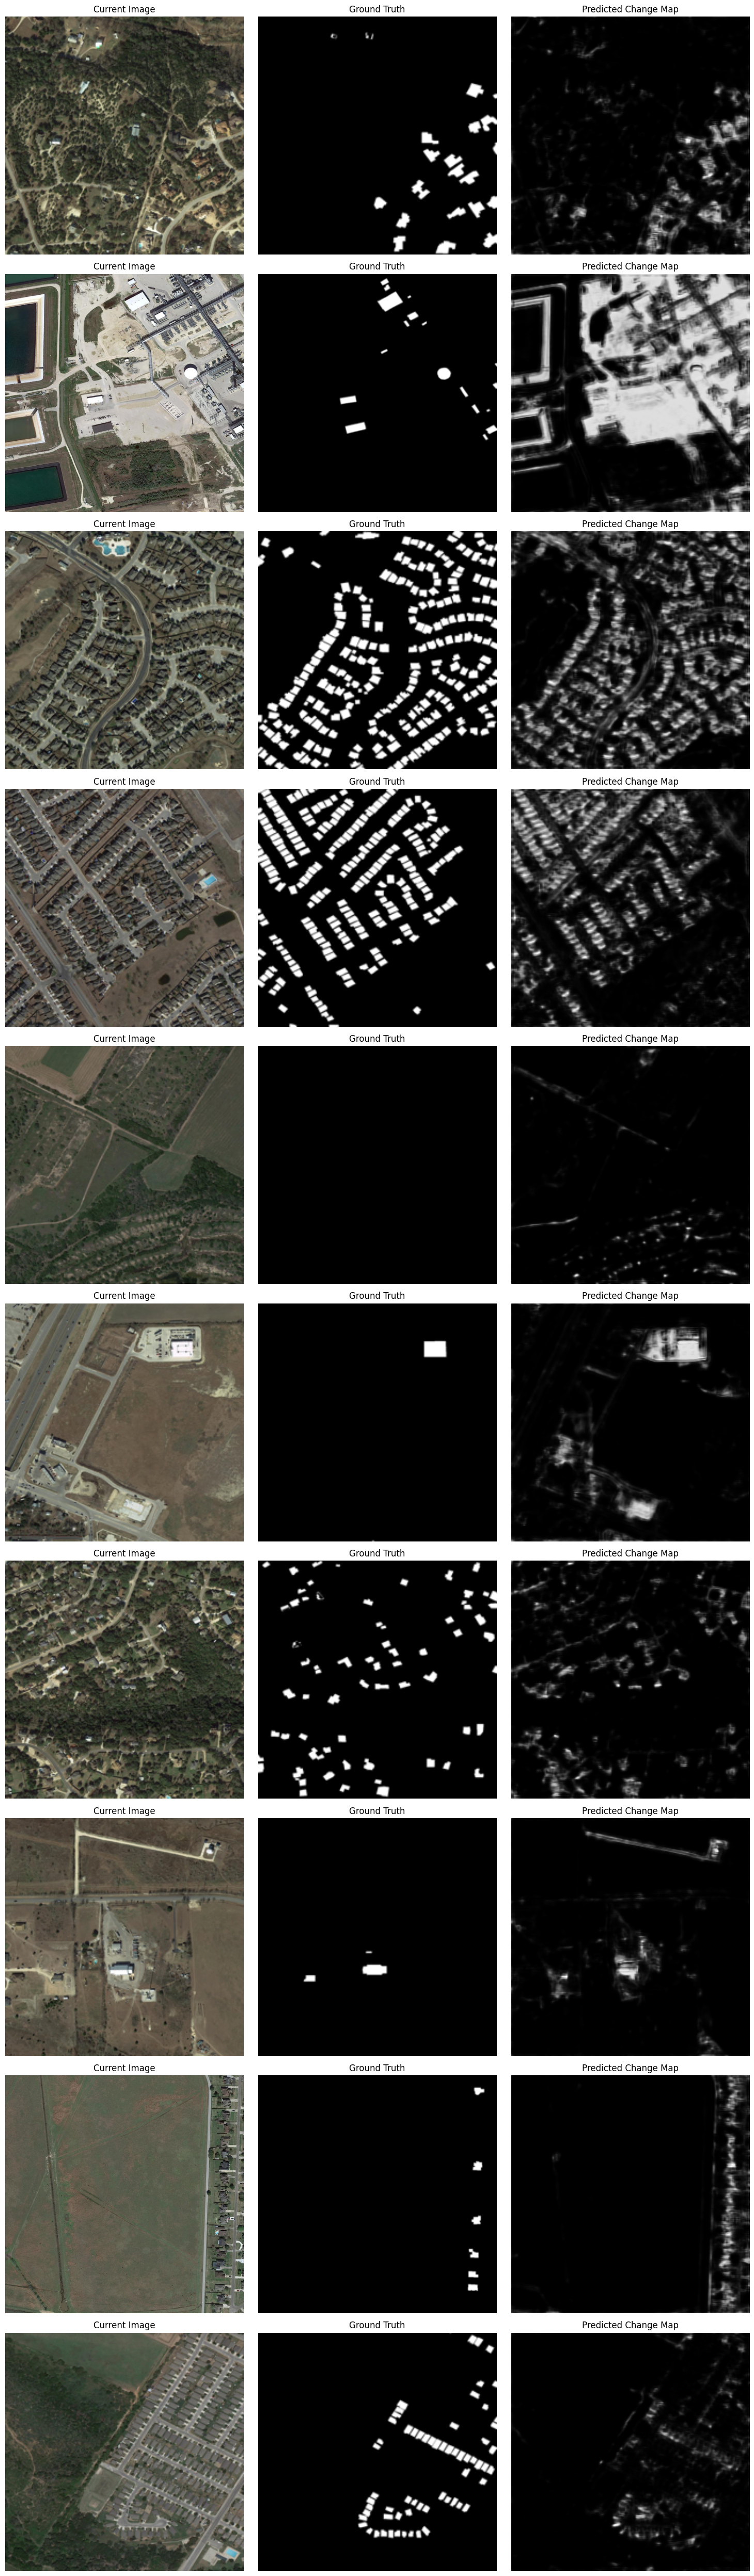

In [14]:
# Visualize the results
num_images = len(all_outputs)
max_images = 10  # Limit the number of images to display
fig, axes = plt.subplots(min(num_images, max_images), 3, figsize=(15, 5 * min(num_images, max_images)))

for i in range(min(num_images, max_images)):
    current_image = Image.open(all_image_paths[i][0]).convert('RGB')
    past_image = Image.open(all_image_paths[i][0].replace('current', 'past')).convert('RGB')
    mask = all_masks[i].squeeze().numpy()
    output = all_outputs[i].squeeze().numpy()
    
    axes[i, 0].imshow(current_image)
    axes[i, 0].set_title('Current Image')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(output, cmap='gray')
    axes[i, 2].set_title('Predicted Change Map')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()